# **Imports**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
from google.colab import files
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.utils import resample

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import tensorflow as tf

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
uploaded = files.upload()

Saving heart_combined.csv to heart_combined.csv


In [3]:
df = pd.read_csv(io.BytesIO(uploaded['heart_combined.csv']))

# **Data Preprocessing**

## Encoding
| Sex        | ChestPainType  | RestingECG  | ExerciseAngina  | ST_Slope  |
|------------|----------------|-------------|-----------------|-----------|
| Female -> 0|   ASY -> 0     | LVH -> 0    | N -> 0          | Down -> 0 |
| Male -> 1  |   ATA -> 1     | Normal -> 1 | Y -> 1          | Flat -> 1 |
|            |   NAP -> 2     | ST -> 2     |                 | Up -> 2   |
|            |   TA -> 3      |             |                 |           |


In [4]:
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])
df['ChestPainType'] = le.fit_transform(df['ChestPainType'])
df['RestingECG'] = le.fit_transform(df['RestingECG'])
df['ExerciseAngina'] = le.fit_transform(df['ExerciseAngina'])
df['ST_Slope'] = le.fit_transform(df['ST_Slope'])
df['Cholesterol'] = df['Cholesterol'].replace(0, df['Cholesterol'].mean().__round__())
X = df.drop(['HeartDisease'], axis=1)
y = df['HeartDisease']

# **Data Visualization & Analysis**

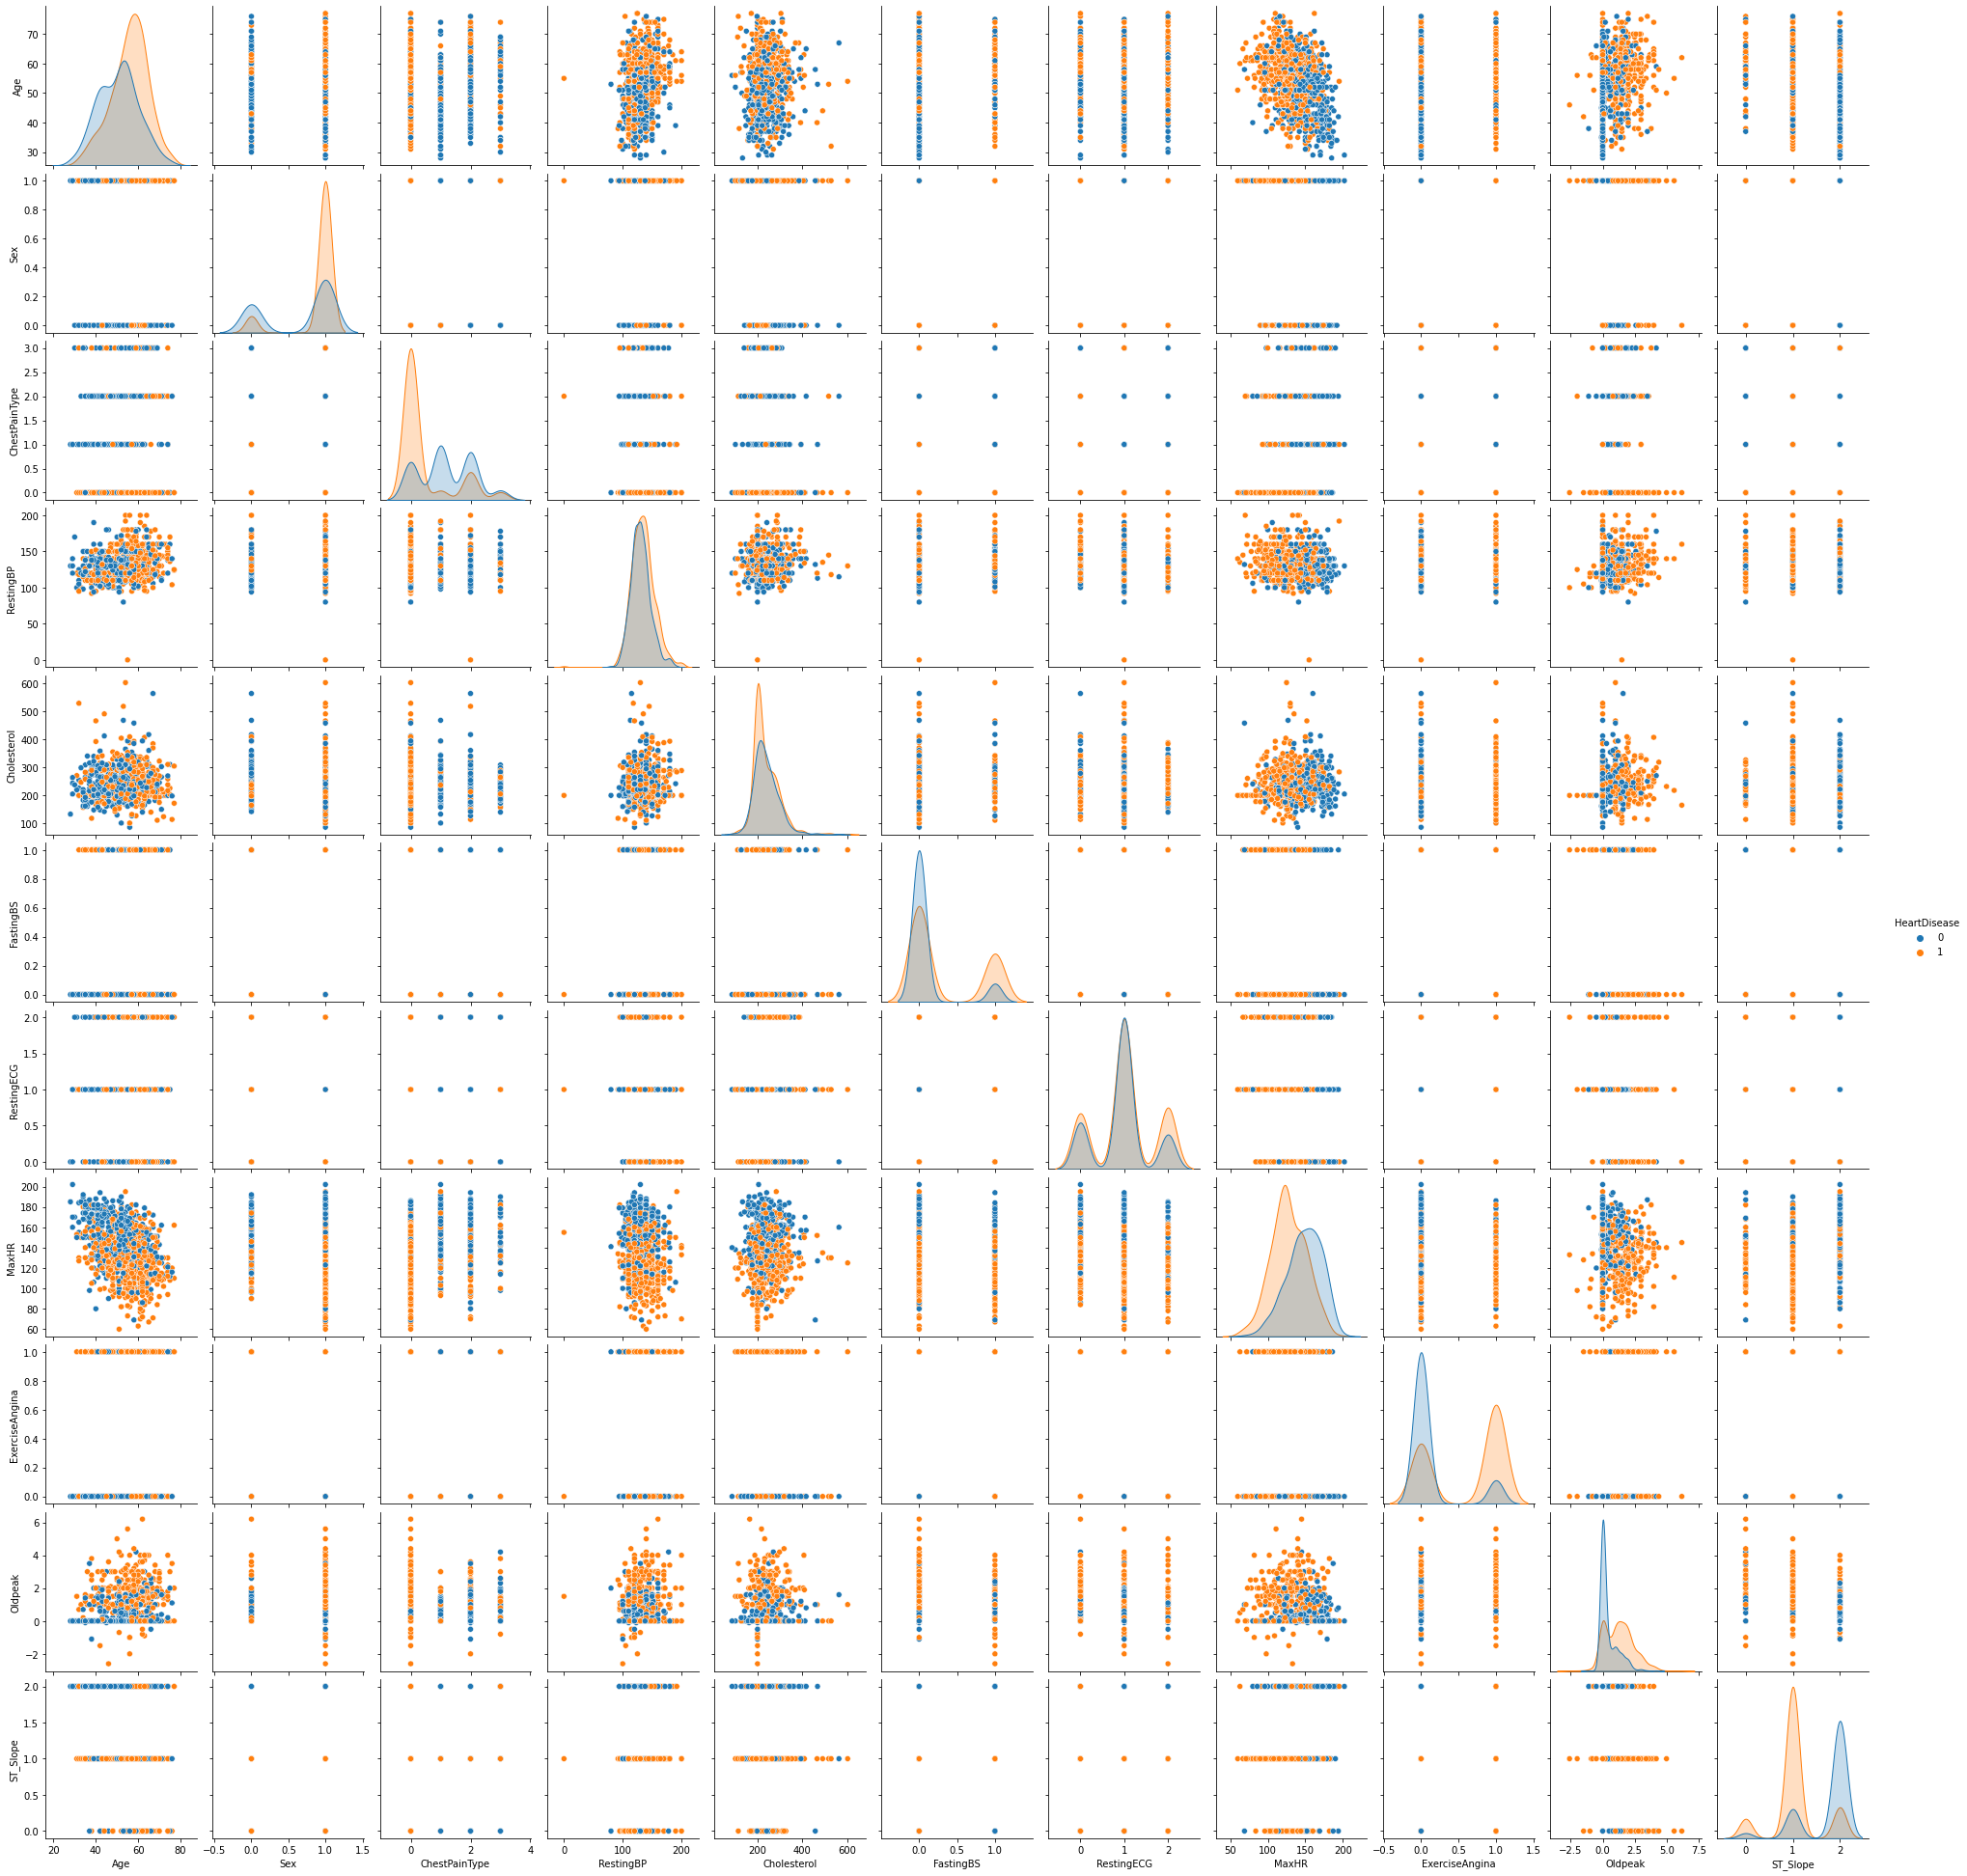

In [ ]:
# Pair Plot
sns.pairplot(df, hue='HeartDisease')

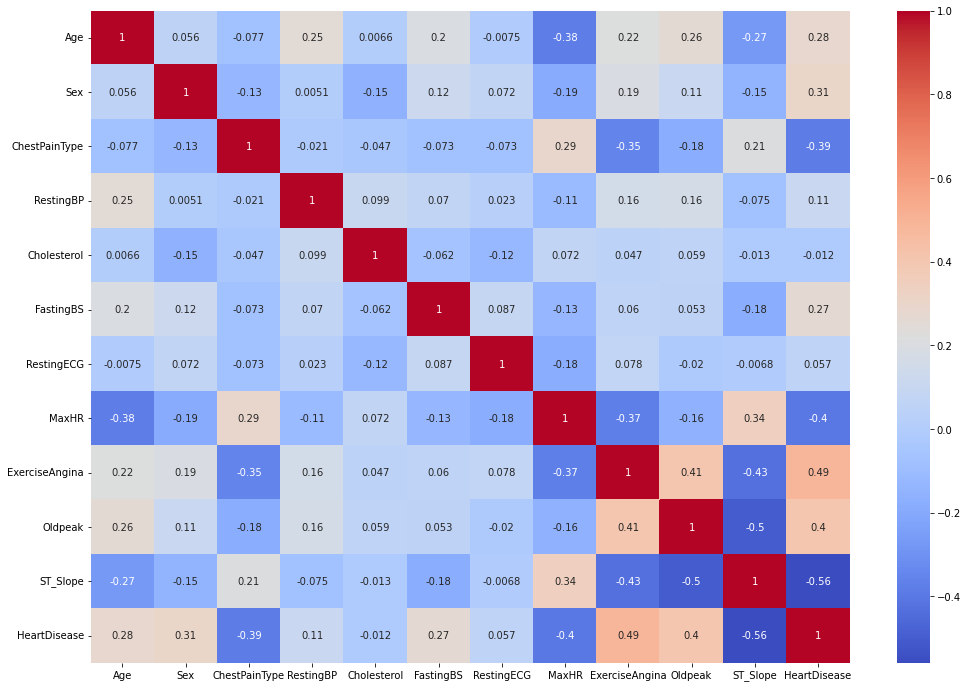

In [ ]:
# Heatmap to find correlation between variables
plt.figure(figsize=(17, 12))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

In [ ]:
#chi squared K best features
bestfeatures = SelectKBest(score_func=chi2, k=3)    
fit = bestfeatures.fit(X.drop(['Oldpeak'], axis=1), y)
columns = pd.DataFrame(X.drop(['Oldpeak'], axis=1).columns)
scores = pd.DataFrame(fit.scores_)
featureScores = pd.concat([columns, scores], axis=1)
featureScores.columns = ['Specs', 'Score']
print(featureScores.nlargest(3, 'Score'))

Index(['ChestPainType', 'MaxHR', 'ExerciseAngina'], dtype='object')


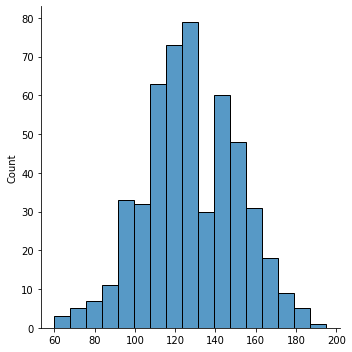

In [ ]:
#Max HR histogram
HeartDisease_1_df = df[df['HeartDisease'] == 1]
maxHR_HeartDisease = HeartDisease_1_df['MaxHR'].values
# plt.hist(maxHR_HeartDisease,bins = np.linspace(0, 600, 600),color = "firebrick", edgecolor = "black")
# plt.xlabel(" Max Heart Rate[bps]")
# plt.ylabel("Frequency")
sns.displot(maxHR_HeartDisease)


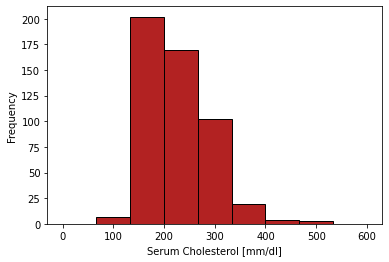

In [ ]:
HeartDisease_1_df = df[df['HeartDisease'] == 1]
Cholesterol_HeartDisease = HeartDisease_1_df['Cholesterol'].values
plt.hist(Cholesterol_HeartDisease,bins = np.linspace(0, 600, 10),color = "firebrick", edgecolor = "black")
plt.xlabel("Serum Cholesterol [mm/dl]")
plt.ylabel("Frequency")
plt.show()

#High blood cholesterol levels are a risk factor for heart disease. However, 
#dietary cholesterol has little to no effect on blood cholesterol levels in most people. 
#More importantly, there is no significant link between the cholesterol you eat and your risk of heart disease.

In [ ]:
print("Maximum age present in the dataset: ", df["Age"].max())
print("Minimum age present in the dataset: ", df["Age"].min())

Maximum age present in the dataset:  77
Minimum age present in the dataset:  28


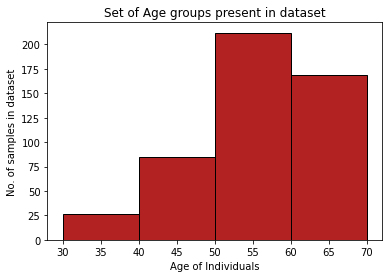

In [ ]:
# Histogram plot for ages of individuals suffering from Heart Diseases
Age_HeartDisease = HeartDisease_1_df['Age'].values
plt.hist(Age_HeartDisease, color = "firebrick", edgecolor = "black",bins = np.linspace(30,70,5))
plt.title("Set of Age groups present in dataset")
plt.xlabel("Age of Individuals")
plt.ylabel("No. of samples in dataset")
plt.show()

In [ ]:
print("No. of males present in the dataset: ", df[df["Sex"]==1].shape[0])
print("No. of females present in the dataset: ", df[df["Sex"]==0].shape[0])

No. of males present in the dataset:  725
No. of females present in the dataset:  193


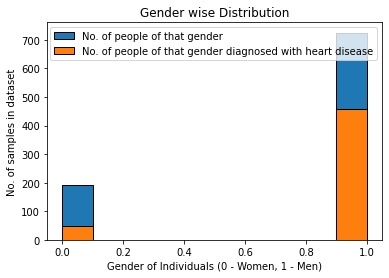

Percentage of males suffering from Heart Diseases: 63.172413793103445
Percentage of females suffering from Heart Diseases: 25.906735751295333


In [ ]:
# Analyzing on the basis of gender to get a better esitmate of who is more susceptible to heart disease 
affected = df[df["HeartDisease"] == 1]
plt.hist(df["Sex"], edgecolor = "black")
plt.hist(affected["Sex"], edgecolor = "black")
plt.title("Gender wise Distribution")
plt.xlabel("Gender of Individuals (0 - Women, 1 - Men)")
plt.ylabel("No. of samples in dataset")
plt.legend(['No. of people of that gender',
            'No. of people of that gender diagnosed with heart disease'])
plt.show()

male_count = df[df["Sex"]==1].shape[0]
female_count = df[df["Sex"]==0].shape[0]
male_positive_count = HeartDisease_1_df[HeartDisease_1_df["Sex"] == 1].shape[0]
female_positive_count = HeartDisease_1_df[HeartDisease_1_df["Sex"] == 0].shape[0]
percent_male = male_positive_count/male_count * 100
percent_female = female_positive_count/female_count * 100
print("Percentage of males suffering from Heart Diseases:", percent_male)
print("Percentage of females suffering from Heart Diseases:", percent_female)

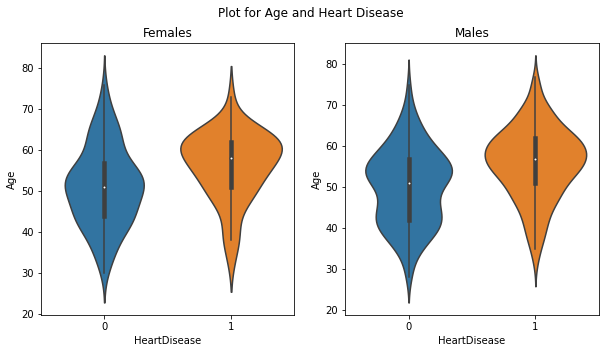

In [ ]:
# Violin Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Plot for Age and Heart Disease")
axes[0].set_title("Females")
axes[1].set_title("Males")
sns.violinplot(ax=axes[0], x='HeartDisease', y='Age', data=df[df['Sex']==0])
sns.violinplot(ax=axes[1], x='HeartDisease', y='Age', data=df[df['Sex']==1])
plt.show()

## TSNE

In [ ]:
tsne = TSNE(n_components=2, perplexity=40)
z = tsne.fit_transform(X)

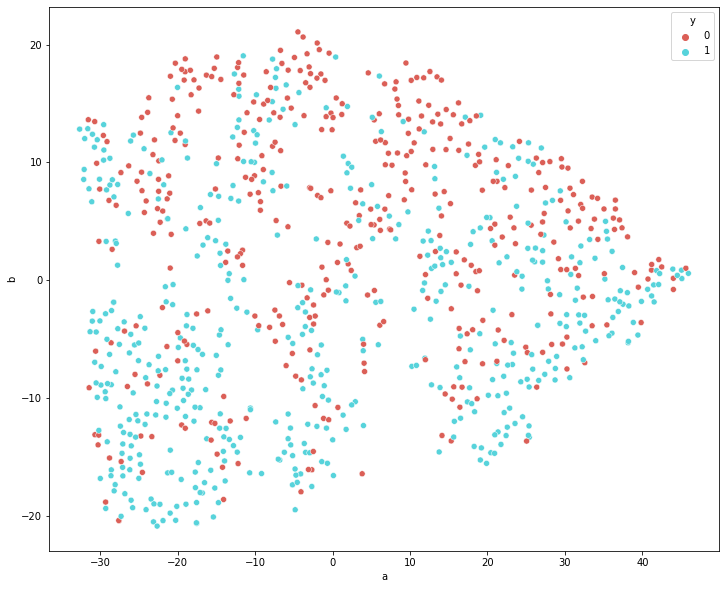

In [ ]:
df_temp = df.copy(deep=True)
df_temp["y"] = y
df_temp['a'] = z[:, 0]
df_temp['b'] = z[:, 1]
plt.figure(figsize=(12, 10))
sns.scatterplot(x="a", y="b", hue="y", palette=sns.color_palette("hls", len(df_temp["y"].unique())), data=df_temp)

# **Helper Functions**

## Confusion Matrix Function

In [5]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')

## ROC Curve Function

In [6]:
def plot_roc_curve(clf, X_test, y_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc='lower right')
    plt.show()

## Model Training & Evaluation Function

In [7]:
def model(clf):
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for i in range(100):
        data = resample(df, n_samples=int(0.8*len(df)), random_state=i)
        X = data.drop(['HeartDisease'], axis=1)
        y = data['HeartDisease']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=10)
        y_pred = clf.fit(X_train, y_train).predict(X_test)
        accuracy.append(accuracy_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred))

    plot_confusion_matrix(y_test, y_pred)
    plot_roc_curve(clf, X_test, y_test)
    return np.mean(accuracy), np.mean(precision), np.mean(recall), np.mean(f1), X_train, X_test, y_train, y_test

# **Models**

## Logistic Regression

### Model Training & Evaluation

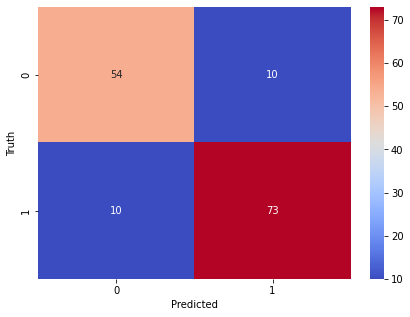

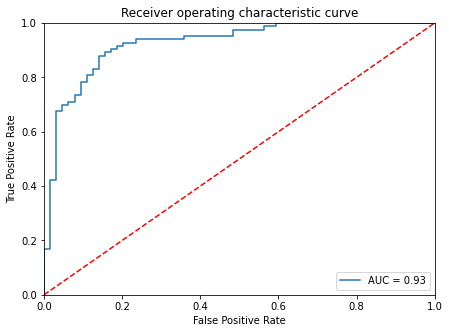

Logistic Regression model accuracy(in %): 84.46258503401359
Logistic Regression model precision(in %): 85.64734821411423
Logistic Regression model recall(in %): 86.44001337330516
Logistic Regression model f1 score(in %): 85.97872197896


In [ ]:
lr_model = LogisticRegression(C=1000, max_iter=100)
accuracy, precision, recall, f1, X_train, X_test, y_train, y_test = model(lr_model)
print("Logistic Regression model accuracy(in %):", accuracy*100)
print("Logistic Regression model precision(in %):", precision*100)
print("Logistic Regression model recall(in %):", recall*100)
print("Logistic Regression model f1 score(in %):", f1*100)

### Hyperparameter Tuning

In [ ]:
param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'max_iter': [100, 250, 500, 1000]}
grid_search = GridSearchCV(lr_model, param_grid_lr, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print("Test set score:", grid_search.score(X_test, y_test))

Best parameters: {'C': 1000, 'max_iter': 100}
Best cross-validation score: 0.8466898449949298
Test set score: 0.8639455782312925


## Gaussian Naive Bayes

### Model Training & Evaluation

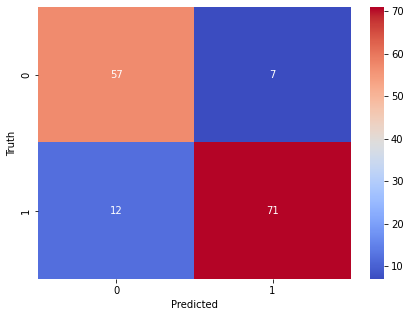

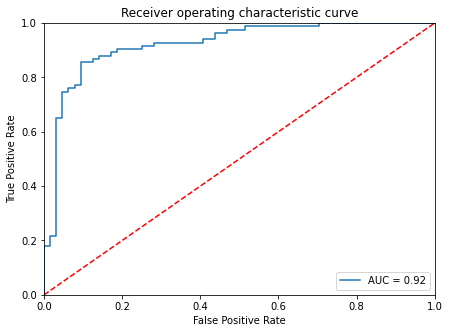

Gaussian Naive Bayes model accuracy(in %): 83.74149659863946
Gaussian Naive Bayes model precision(in %): 87.07962526090432
Gaussian Naive Bayes model recall(in %): 82.98277408400725
Gaussian Naive Bayes model f1 score(in %): 84.90892908475898


In [ ]:
gnb_model = GaussianNB(var_smoothing=1e-05, priors=[0.5, 0.5])
accuracy, precision, recall, f1, X_train, X_test, y_train, y_test = model(gnb_model)
print("Gaussian Naive Bayes model accuracy(in %):", accuracy*100)
print("Gaussian Naive Bayes model precision(in %):", precision*100)
print("Gaussian Naive Bayes model recall(in %):", recall*100)
print("Gaussian Naive Bayes model f1 score(in %):", f1*100)

### Hyperparameter Tuning

In [ ]:
param_grid_gnb = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], 'priors': [None, [0.5, 0.5], [0.6, 0.4], [0.7, 0.3], [0.8, 0.2], [0.9, 0.1]]}
grid_search = GridSearchCV(gnb_model, param_grid_gnb, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print("Test set score:", grid_search.score(X_test, y_test))

Best parameters: {'priors': [0.5, 0.5], 'var_smoothing': 1e-05}
Best cross-validation score: 0.8603505722149789
Test set score: 0.8707482993197279


## Bernoulli Naive Bayes

### Model Training & Evaluation

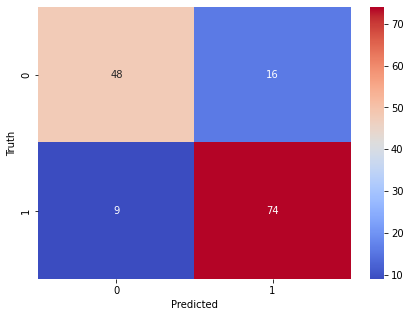

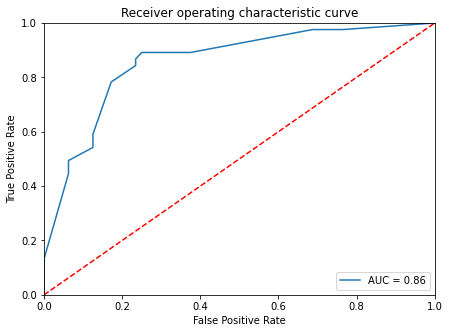

Bernoulli Naive Bayes model accuracy(in %): 82.74829931972788
Bernoulli Naive Bayes model precision(in %): 81.22981368734919
Bernoulli Naive Bayes model recall(in %): 89.60940439812882
Bernoulli Naive Bayes model f1 score(in %): 85.16746309603884


In [ ]:
bnb_model = BernoulliNB(alpha=100, binarize=1.0, fit_prior=True)
accuracy, precision, recall, f1, X_train, X_test, y_train, y_test = model(bnb_model)
print("Bernoulli Naive Bayes model accuracy(in %):", accuracy*100)
print("Bernoulli Naive Bayes model precision(in %):", precision*100)
print("Bernoulli Naive Bayes model recall(in %):", recall*100)
print("Bernoulli Naive Bayes model f1 score(in %):", f1*100)

### Hyperparameter Tuning

In [ ]:
param_grid_bnb = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'binarize': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'fit_prior': [True, False]}
grid_search = GridSearchCV(bnb_model, param_grid_bnb, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print("Test set score:", grid_search.score(X_test, y_test))

Best parameters: {'alpha': 100, 'binarize': 1.0, 'fit_prior': True}
Best cross-validation score: 0.8416195856873824
Test set score: 0.8299319727891157


## Random Forest Classifier

### Model Training & Evaluation

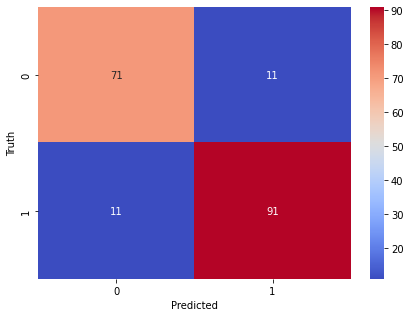

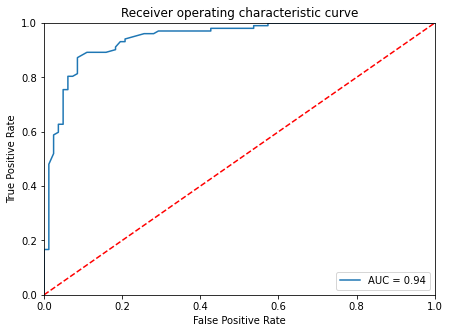

Random Forest model accuracy(in %): 88.04347826086956
Random Forest model precision(in %): 89.2156862745098
Random Forest model recall(in %): 89.2156862745098
Random Forest model f1 score(in %): 89.2156862745098


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=10)
rfc_model = RandomForestClassifier(n_estimators=100, max_depth=15, bootstrap=True, criterion='entropy', warm_start=True, oob_score=True, max_features='sqrt')
y_pred = rfc_model.fit(X_train, y_train).predict(X_test)
plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(rfc_model, X_test, y_test)
print("Random Forest model accuracy(in %):", accuracy_score(y_test, y_pred)*100)
print("Random Forest model precision(in %):", precision_score(y_test, y_pred)*100)
print("Random Forest model recall(in %):", recall_score(y_test, y_pred)*100)
print("Random Forest model f1 score(in %):", f1_score(y_test, y_pred)*100)

### Hyperparameter Tuning

In [ ]:
param_grid_rfc = {'n_estimators': [100, 250, 500], 'max_depth': [7, 10, 15], 'criterion': ['gini', 'entropy'], 'max_features': ['sqrt', 'log2']}
grid_search = GridSearchCV(rfc_model, param_grid_rfc, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print("Test set score:", grid_search.score(X_test, y_test))

Best parameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 250}
Best cross-validation score: 0.8610753890597336
Test set score: 0.8804347826086957


### Adaboost

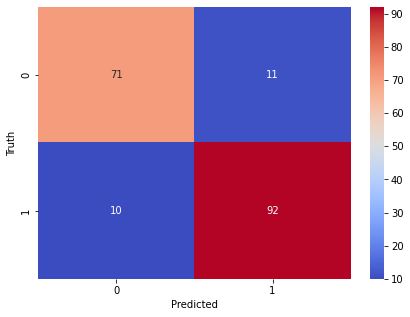

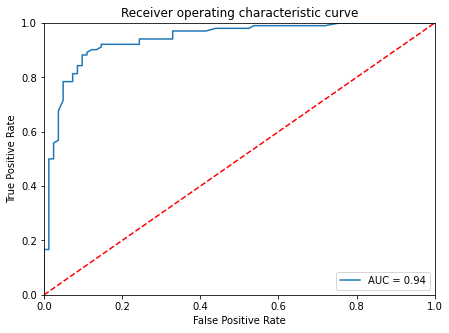

AdaBoost model accuracy(in %): 88.58695652173914
AdaBoost model precision(in %): 89.32038834951457
AdaBoost model recall(in %): 90.19607843137256
AdaBoost model f1 score(in %): 89.75609756097562


In [ ]:
ada_model = AdaBoostClassifier(base_estimator=rfc_model, n_estimators=100, learning_rate=0.2)
y_pred = ada_model.fit(X_train, y_train).predict(X_test)
plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(ada_model, X_test, y_test)
print("AdaBoost model accuracy(in %):", accuracy_score(y_test, y_pred)*100)
print("AdaBoost model precision(in %):", precision_score(y_test, y_pred)*100)
print("AdaBoost model recall(in %):", recall_score(y_test, y_pred)*100)
print("AdaBoost model f1 score(in %):", f1_score(y_test, y_pred)*100)

## Feature Importance Graph

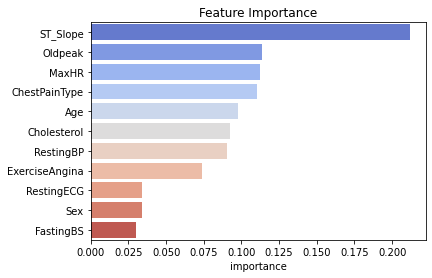

In [ ]:
feature_importances = pd.DataFrame(rfc_model.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
sns.barplot(x=feature_importances['importance'], y=feature_importances.index, palette='coolwarm')
plt.title('Feature Importance')
plt.show()

## K-Nearest Neighbours

### Model Training and Evaluation

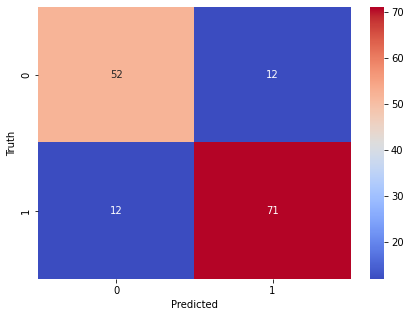

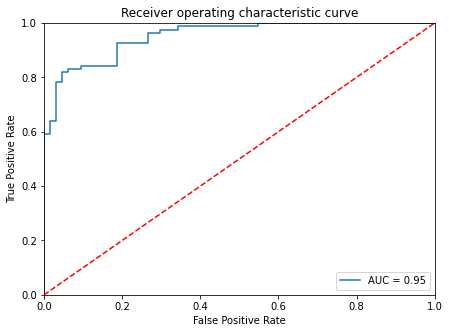

KNN model accuracy(in %): 85.27891156462584
KNN model precision(in %): 85.12658876823271
KNN model recall(in %): 89.01218993216885
KNN model f1 score(in %): 86.9526695828899


In [ ]:
knn = KNeighborsClassifier(n_neighbors=49, weights='distance', metric='manhattan', n_jobs=-1)
knn_accuracy, knn_precision, knn_recall, knn_f1, X_train, X_test, y_train, y_test = model(knn)
print("KNN model accuracy(in %):", knn_accuracy*100)
print("KNN model precision(in %):", knn_precision*100)
print("KNN model recall(in %):", knn_recall*100)
print("KNN model f1 score(in %):", knn_f1*100)

### Hyperparameter Tuning

In [ ]:
param_grid = {'n_neighbors': np.arange(1, 50), 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
knn_cv = GridSearchCV(knn, param_grid, n_jobs=-1)
knn_cv.fit(X_train, y_train)
print("Best parameters:", knn_cv.best_params_)
print("Best score:", knn_cv.best_score_)
print("Test set score:", knn_cv.score(X_test, y_test))

Best parameters: {'metric': 'manhattan', 'n_neighbors': 49, 'weights': 'distance'}
Best score: 0.8415906127770535
Test set score: 0.8367346938775511


## SVM

### Model Training and Evaluation

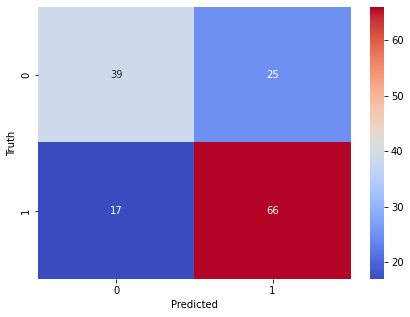

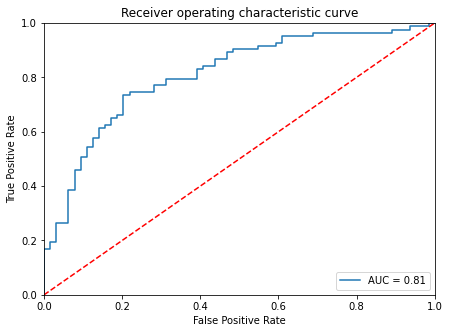

SVM model accuracy(in %): 69.10204081632654
SVM model precision(in %): 70.01764464128286
SVM model recall(in %): 77.197136994668
SVM model f1 score(in %): 73.32275427981719


In [ ]:
svm = SVC(probability=True)
svm_accuracy, svm_precision, svm_recall, svm_f1, X_train, X_test, y_train, y_test = model(svm)
print("SVM model accuracy(in %):", svm_accuracy*100)
print("SVM model precision(in %):", svm_precision*100)
print("SVM model recall(in %):", svm_recall*100)
print("SVM model f1 score(in %):", svm_f1*100)

### Hyperparameter Tuning

In [ ]:
param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['rbf', 'poly', 'sigmoid']}
svm_cv = GridSearchCV(svm, param_grid, n_jobs=-1)
svm_cv.fit(X_train, y_train)
print("Best parameters:", svm_cv.best_params_)
print("Best score:", svm_cv.best_score_)
print("Test set score:", svm_cv.score(X_test, y_test))

## XGBoost

### Model Training and Evaluation

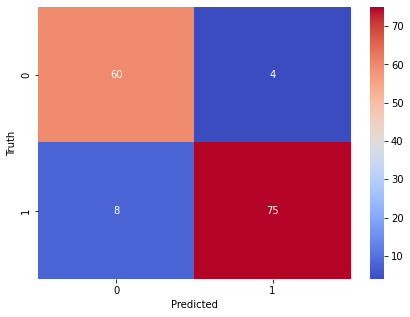

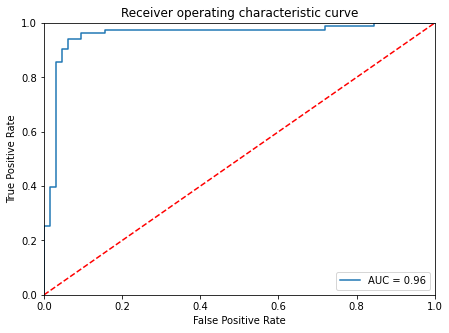

XGBoost model accuracy(in %): 91.68707482993197
XGBoost model precision(in %): 91.71112683945368
XGBoost model recall(in %): 93.46403193283443
XGBoost model f1 score(in %): 92.54236084526252


In [9]:
xgb = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=500, n_jobs=-1)
xgb_accuracy, xgb_precision, xgb_recall, xgb_f1, X_train, X_test, y_train, y_test = model(xgb)
print("XGBoost model accuracy(in %):", xgb_accuracy*100)
print("XGBoost model precision(in %):", xgb_precision*100)
print("XGBoost model recall(in %):", xgb_recall*100)
print("XGBoost model f1 score(in %):", xgb_f1*100)

### Hyperparameter Tuning

In [ ]:
param_grid = {'learning_rate': [0.1, 0.01, 0.001], 'max_depth': [3, 5, 10], 'n_estimators': [100, 250, 500, 1000], 'gamma': [0.1, 0.3, 0.5], 'reg_alpha': [0.1, 0.3, 0.5], 'reg_lambda': [0.1, 0.3, 0.5]}
xgb_cv = GridSearchCV(xgb, param_grid, n_jobs=-1)
xgb_cv.fit(X_train, y_train)
print("Best parameters:", xgb_cv.best_params_)
print("Best score:", xgb_cv.best_score_)
print("Test set score:", xgb_cv.score(X_test, y_test))

Best parameters: {'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
Best score: 0.9216862233811387
Test set score: 0.9183673469387755


## LightGBM

### Model Training and Evaluation

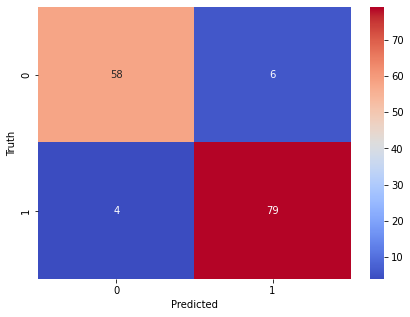

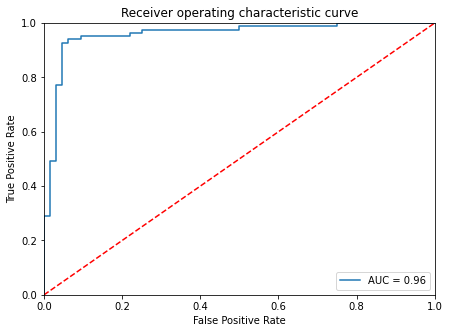

LightGBM model accuracy(in %): 91.66666666666667
LightGBM model precision(in %): 91.60878805944975
LightGBM model recall(in %): 93.5651940933696
LightGBM model f1 score(in %): 92.53880924774029


In [8]:
# lgbm = LGBMClassifier(learning_rate=0.1, max_depth=3, n_estimators=100, n_jobs=-1)
lgbm = LGBMClassifier(learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=20, reg_alpha=0.3, reg_lambda=0.1, n_jobs=-1)
lgbm_accuracy, lgbm_precision, lgbm_recall, lgbm_f1, X_train, X_test, y_train, y_test = model(lgbm)
print("LightGBM model accuracy(in %):", lgbm_accuracy*100)
print("LightGBM model precision(in %):", lgbm_precision*100)
print("LightGBM model recall(in %):", lgbm_recall*100)
print("LightGBM model f1 score(in %):", lgbm_f1*100)

### Hyperparameter Tuning

In [ ]:
param_grid = {'learning_rate': [0.1, 0.01, 0.001], 'max_depth': [3, 5, 10], 'n_estimators': [100, 250, 500, 1000], 'num_leaves': [10, 20, 30, 40, 50], 'reg_alpha': [0.1, 0.3, 0.5], 'reg_lambda': [0.1, 0.3, 0.5]}
lgbm_cv = GridSearchCV(lgbm, param_grid, n_jobs=-1)
lgbm_cv.fit(X_train, y_train)
print("Best parameters:", lgbm_cv.best_params_)
print("Best score:", lgbm_cv.best_score_)
print("Test set score:", lgbm_cv.score(X_test, y_test))

## Artificial Neural Network

In [52]:
X = np.array(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=10)
model = Sequential()
lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)

model.add(Dense(11, input_shape=(X.shape[1],), activation=lrelu))
model.add(Dense(24, activation=lrelu))
model.add(Dense(16, activation=lrelu))
model.add(Dense(8, activation=lrelu))
model.add(Dense(4, activation=lrelu))
model.add(Dense(1, activation='sigmoid'))
model.summary() 

model.compile(optimizer='Adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# optimizer = tf.keras.optimizers.RMSprop(0.001)
# model.compile(loss='mse',
#                 optimizer=optimizer,
#                 metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', 
                            mode='max',
                            patience=25,
                            restore_best_weights=True)

history = model.fit(X_train, y_train,
                    callbacks=es,
                    epochs=250, 
                    batch_size=25,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_77 (Dense)            (None, 11)                132       
                                                                 
 dense_78 (Dense)            (None, 24)                288       
                                                                 
 dense_79 (Dense)            (None, 16)                400       
                                                                 
 dense_80 (Dense)            (None, 8)                 136       
                                                                 
 dense_81 (Dense)            (None, 4)                 36        
                                                                 
 dense_82 (Dense)            (None, 1)                 5         
                                                                 
Total params: 997
Trainable params: 997
Non-trainable

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


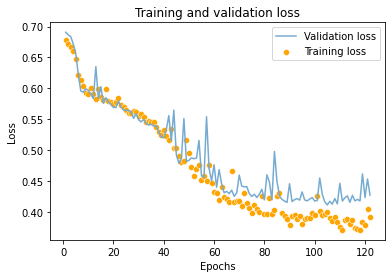

In [53]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 

sns.scatterplot(epochs, loss_values, label='Training loss', color='orange')
sns.lineplot(epochs, val_loss_values, label='Validation loss', color='#76abd1')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


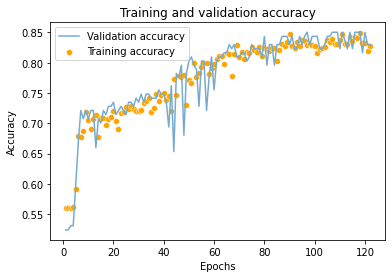

0.8503401279449463

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
sns.scatterplot(epochs, acc, label='Training accuracy', color='orange')
sns.lineplot(epochs, val_acc, label='Validation accuracy', color='#76abd1')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
np.max(val_acc)

In [55]:
preds = np.round(model.predict(X_test),0)
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

6/6 [==============================] - 0s 2ms/step
[[68 14]
 [14 88]]
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        82
           1       0.86      0.86      0.86       102

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184

